# ResNet 101

## Tensorflow ResNet_v1 from tf-slim


In [62]:
#importing the necessary dependencies
%load_ext autoreload
%autoreload 2


from layers import Fixations
try:
    from urllib.request import urlretrieve
except:
    from urllib import urlretrieve
    
from utils import *
from utils_resnet import *


BACKEND = 'tf'
if BACKEND=='tf':
    from tf_helpers_slim_resnet import Net, Data
else: 
    from caffe.proto import caffe_pb2
    import caffe
import os

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#initializing the model

if BACKEND == 'tf':    
    checkpoint_path = os.path.join('../models', 'resnet_101', 'resnet_v1_101.ckpt')
    net = Net(checkpoint_path)
else:
    #Specifying to use the GPU
    caffe.set_mode_gpu()
    caffe.set_device(0)

    net = caffe.Classifier('../models/resnet_101/deploy.prototxt','../models/resnet_101/ResNet-101-model.caffemodel',channel_swap=(2,1,0))
    
layers = Fixations(net)

net: Tensor("resnet_v1_101/logits/BiasAdd:0", shape=(1, 1, 1, 1000), dtype=float32)
INFO:tensorflow:Restoring parameters from ../models/resnet_101/resnet_v1_101.ckpt
add caffe resnet layer (data): images
param_name: images
param_tensor: Tensor("images:0", shape=(1, 224, 224, 3), dtype=float32)
skip  labels
skip  resnet_v1_101/Pad/paddings
skip  resnet_v1_101/Pad
skip  resnet_v1_101/conv1/weights
skip  resnet_v1_101/conv1/weights/Assign
skip  resnet_v1_101/conv1/weights/read
skip  resnet_v1_101/conv1/dilation_rate
skip  resnet_v1_101/conv1/Conv2D
add caffe resnet layer (conv1): resnet_v1_101/conv1/Relu
param_name: resnet_v1_101/conv1/weights
param_tensor: Tensor("resnet_v1_101/conv1/weights:0", shape=(7, 7, 3, 64), dtype=float32_ref)
add caffe resnet layer (pool1): resnet_v1_101/pool1/MaxPool
param_name: resnet_v1_101/pool1/MaxPool
param_tensor: Tensor("resnet_v1_101/pool1/MaxPool:0", shape=(1, 56, 56, 64), dtype=float32)
skip  resnet_v1_101/block1/unit_1/bottleneck_v1/shortcut/weights


skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/weights
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/weights/Assign
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/weights/read
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/dilation_rate
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/Conv2D
add caffe resnet layer (res4b14_branch2b): resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/Relu
param_name: resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/weights
param_tensor: Tensor("resnet_v1_101/block3/unit_15/bottleneck_v1/conv2/weights:0", shape=(3, 3, 256, 256), dtype=float32_ref)
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv3/weights
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv3/weights/Assign
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv3/weights/read
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv3/dilation_rate
skip  resnet_v1_101/block3/unit_15/bottleneck_v1/conv3/Conv2D
add caffe resnet layer (res4b14_branch2c): r

In [64]:
if BACKEND == 'tf':
    def resnet(points, inc, resFac):
        points = layers.fc(points=points, layer='fc1000', prevLayer='pool5')
        points = layers.pool(points=points, prevLayer='res5c', K=7, S=1)
        blob_list = ['pool1',\
                     '2a', '2b', '2c',\
                     '3a', '3b1', '3b2', '3b3',\
                     '4a', '4b1', '4b2', '4b3', '4b4', '4b5', '4b6', '4b7', '4b8', '4b9',\
                           '4b10', '4b11', '4b12', '4b13', '4b14', '4b15', '4b16', '4b17', '4b18', '4b19', '4b20',\
                           '4b21', '4b22',\
                     '5a', '5b', '5c']
        for i in range(len(blob_list)-1,0,-1):
            # Note that points after 4b22, 3b3, 2c feautre map index is not yet determined. 
            # For example, it requires 4b22's internal conv weights to map 2048 to 1024.
            # print("points (after {}): {}".format(blob_list[i], points))
            points = layers.res(points, blob_list[i], blob_list[i-1], network_name="tf_slim_resnet_v1_101")

        # print("points (after {}): {}".format("pool1", points))
        points = layers.pool(points=points, prevLayer='conv1',K=3, S=2)
        # print("points (after {}): {}".format("conv1", points))
        points = layers.conv(points=points,  layer='conv1', prevLayer='data', K=7, S=2, P=3)
        # print("points (after {}): {}".format("data", points))
        points = layers.data(points=points, inc=inc, resFac=resFac)
        # print("points raw: {}".format(points))
        return points
else:    
    def resnet(points, inc, resFac):
        points = layers.fc(points=points, layer='fc1000', prevLayer='pool5')
        points = layers.pool(points=points, prevLayer='res5c', K=7, S=1)
        blob_list = ['pool1', '2a', '2b', '2c', '3a', '3b1', '3b2', '3b3', '4a', '4b1', '4b2', '4b3', '4b4', '4b5', '4b6', '4b7', '4b8', '4b9',
             '4b10', '4b11', '4b12', '4b13', '4b14', '4b15', '4b16', '4b17', '4b18', '4b19', '4b20', '4b21', '4b22', '5a', '5b', '5c']
        for i in range(len(blob_list)-1,0,-1):
                    points = layers.res(points, blob_list[i], blob_list[i-1])
        points = layers.pool(points=points, prevLayer='conv1',K=3, S=2)
        points = layers.conv(points=points,  layer='conv1', prevLayer='data', K=7, S=2, P=3)
        points = layers.data(points=points, inc=inc, resFac=resFac)
        return points
    

img shape: (256, 312, 3)
image_label: spoonbill


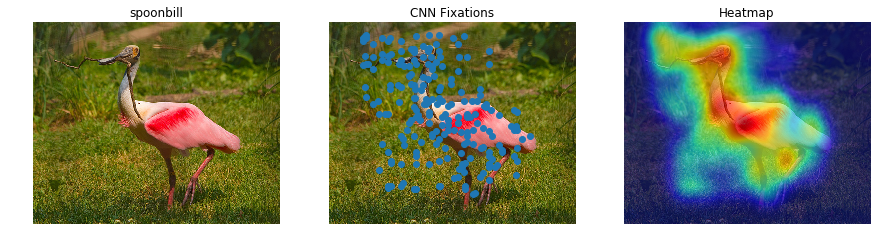

In [66]:
import matplotlib.pyplot as plt

%matplotlib inline

img_path = 'sample.jpg'
# Prediction on ImageNet

img, offset, resFac, newSize = imgPreprocess(img_path=img_path)    
print("img shape:", img.shape)    
net.image_dims = newSize

if BACKEND == 'tf':    
    points, image_label = pred(net, img, oversample=False)
    # print("points (pred):", points) 
    # points = [[582], 0, 0, 0, 0]
    print("image_label:", image_label)
    
    # We use center cropped image as the 1st image, so change offset for it. 
    offset = [offset[4], [0, 0], [0, 0], [0, 0], [0, 0]]
    points = resnet(points, offset, resFac)
    # print(points)    
    # print("points (data):", points)
else:        
    points, image_label = pred(net, img)
    # print("points (pred):", points)
    points = [0, 0, 0, 0, points[4]] # keep only center for fair comparision with tf resnet visualization
    # print("points (pred) modified:", points)
    points = resnet(points, offset, resFac)
    
visualize(img_path, points, diag_percent=0.1, image_label=image_label)